# Quick alignment of spots

In [1]:
# Basic imports
import os,sys,re
from importlib import reload
import numpy as np
import pandas as pd
#import torch
print(os.getpid())

1322740


In [5]:
# ChromAn related imports
sys.path.append(r'/lab/weissman_imaging/puzheng/Softwares/') # parent folder of ChromAn
import h5py
import ast
from ChromAn.src import file_io
from ChromAn.src.file_io import dax_process
from ChromAn.src.file_io import data_organization
from ChromAn.src.visual_tools import interactive
from ChromAn.src.correction_tools.alignment import generate_drift_crops
from ChromAn.src.spot_tools.match_spots import colocalize_spots

In [6]:
# data folder
data_folder = r'/lab/weissman_imaging/puzheng/PE_LT/20231030-top8preEdit400k_zombie'
# scan subfolders
folders, fovs = data_organization.search_fovs_in_folders(data_folder)
# analysis folder
analysis_folder = os.path.join(data_folder, 'Analysis')
# figure_folder
figure_folder = os.path.join(analysis_folder, 'saved_figures_20231018')
if not os.path.exists(figure_folder):
    os.makedirs(figure_folder)

- searching in folder: /lab/weissman_imaging/puzheng/PE_LT/20231030-top8preEdit400k_zombie
-- 19 folders, 181 fovs detected.


In [7]:
color_usage_df = data_organization.Color_Usage(os.path.join(analysis_folder, "Color_Usage.csv"))

- load color_usage from file: /lab/weissman_imaging/puzheng/PE_LT/20231030-top8preEdit400k_zombie/Analysis/Color_Usage.csv


In [11]:
save_folder = analysis_folder
save_filenames = [os.path.join(save_folder, _fl) for _fl in os.listdir(save_folder)
                  if _fl.split(os.extsep)[-1]=='hdf5']
import re
match = re.match(r'.*_([0-9]+).hdf5', os.path.basename(save_filenames[0]), ).groups()[0]
save_filenames = [_f for _f in sorted(save_filenames, 
                                      key=lambda _v:int(re.match(r'.*_([0-9]+).hdf5', os.path.basename(_v), ).groups()[0]))]

# extract fov_id
save_fov_ids = [int(os.path.basename(_fl).split('.hdf5')[0].split('_')[-1]) for _fl in save_filenames]

debug = False

print(f"{len(save_filenames)} fovs detected")


segmentation_folder = os.path.join(analysis_folder, 'Segmentation')
if not os.path.exists(segmentation_folder):
    os.makedirs(segmentation_folder)
    print(f"Creating segmentation_folder: {segmentation_folder}")
else:
    print(f"Use segmentation_folder: {segmentation_folder}")

cand_spot_folder = os.path.join(analysis_folder, 'CandSpots')
if not os.path.exists(cand_spot_folder):
    os.makedirs(cand_spot_folder)
    print(f"Creating cand_spot_folder: {cand_spot_folder}")
else:
    print(f"Use cand_spot_folder: {cand_spot_folder}")

decoder_folder = cand_spot_folder.replace('CandSpots', 'Decoder')
if debug:
    _version = 0
    while os.path.exists(os.path.join(decoder_folder, f'v{_version}')):
        _version += 1
    decoder_folder = os.path.join(decoder_folder, f'v{_version}')
if not os.path.exists(decoder_folder):
    os.makedirs(decoder_folder)
    print(f"Creating decoder_folder: {decoder_folder}")
else:
    print(f"Use decoder_folder: {decoder_folder}")
    
from ChromAn.src.correction_tools.load_corrections import load_correction_profile
from ChromAn.src.correction_tools.chromatic import generate_chromatic_function
correction_folder = r'/lab/weissman_imaging/puzheng/Corrections/20230902-Merscope01_s30_n500'

120 fovs detected
Use segmentation_folder: /lab/weissman_imaging/puzheng/PE_LT/20231030-top8preEdit400k_zombie/Analysis/Segmentation
Use cand_spot_folder: /lab/weissman_imaging/puzheng/PE_LT/20231030-top8preEdit400k_zombie/Analysis/CandSpots
Use decoder_folder: /lab/weissman_imaging/puzheng/PE_LT/20231030-top8preEdit400k_zombie/Analysis/Decoder


In [22]:
from ChromAn.src.file_io.image_crop import generate_neighboring_crop,crop_neighboring_area
from ChromAn.src.spot_tools.spot_class import Spots3D
import pickle
from scipy.stats import scoreatpercentile
import matplotlib.pyplot as plt
def _rescaling(im, vmin=None, vmax=None):
    if vmin is None:
        vmin = np.min(im)
    if vmax is None:
        vmax = np.max(im)
    _res_im = np.clip(im, vmin, vmax)
    _res_im = (_res_im - vmin) / (vmax - vmin)
    _res_im = (_res_im * np.iinfo(np.uint8).max ).astype(np.uint8)
    return _res_im
def rescale_by_percentile(im, min_max_percent=[30,99.95]):
    from scipy.stats import scoreatpercentile
    vmin, vmax = scoreatpercentile(im, min(min_max_percent)), scoreatpercentile(im, max(min_max_percent))
    return _rescaling(im, vmin=vmin, vmax=vmax)

def inside_image(coord, image_size):
    return bool((coord >= np.zeros(len(coord))).all() & (coord <= np.array(image_size)).all())

In [ ]:
%matplotlib inline
overwrite = True
crop_size = 7

# load images:
for _save_filename in save_filenames[:]:
    print(f"Processing: {_save_filename}")
    fovinfo_savefile = os.path.join(analysis_folder, f"{os.path.basename(_save_filename).replace('.hdf5', '_processed_info.pkl')}")
    if os.path.exists(fovinfo_savefile) and not overwrite:
        continue
    # Load
    with h5py.File(_save_filename, 'r') as _f:
        print(f"- loading from file: {_save_filename}")
        _merfish_spots = [Spots3D(_s[_s[:,0] > 0], pixel_size=[500,107,107]) 
                          for _s in _f['merfish']['spots'][:]]
        _merfish_ids = _f['merfish']['ids'][:]
        _merfish_ims = _f['merfish']['ims'][:]
        _merfish_channels = [_ch.decode() for _ch in _f['merfish']['channels'][:]]
        _merfish_drifts = _f['merfish']['drifts'][:]
        # rna
        _rna_spots = [Spots3D(_s[_s[:,0] > 0], pixel_size=[500,107,107]) 
                      for _s in _f['rna']['spots'][:]]
        _rna_ids = _f['rna']['ids'][:]
        _rna_ims = _f['rna']['ims'][:]
        _rna_channels = [_ch.decode() for _ch in _f['rna']['channels'][:]]
        _rna_drifts = _f['rna']['drifts'][:]
        # dapi
        _dapi_im = _f.attrs['dapi_im']
    
    fov_save_infos = []
    
    # Colocalize r2 and m53
    r2_spots = _rna_spots[list(_rna_ids).index(2)]#[:,1:4]

    sv40_spots = _merfish_spots[list(_merfish_ids).index(53)]#[:,1:4]

    sv40_im = _merfish_ims[list(_merfish_ids).index(53)]
    paired_sv40_spots, paired_r2_spots = colocalize_spots(sv40_spots, r2_spots)
    if len(paired_sv40_spots) == 0:
        continue
        
    print(len(r2_spots), len(sv40_spots), len(paired_sv40_spots))
    # process image
    intbc_ids = _merfish_ids[_merfish_ids <= 21]
    intbc_chs = np.array(_merfish_channels)[_merfish_ids <= 21]
    edit_ids = _merfish_ids[(_merfish_ids > 21) & (_merfish_ids < 52)]
    edit_chs = np.array(_merfish_channels)[(_merfish_ids > 21) & (_merfish_ids < 52)]

    # process image
    center_spots = (paired_sv40_spots + paired_r2_spots) / 2

    for _sid, _sel_spot in enumerate(center_spots):
        # IntBC
        intbc_ims = []
        for _id, _ch in zip(intbc_ids, intbc_chs):
            _idx = list(_merfish_ids).index(_id)
            _im, _dft = _merfish_ims[_idx], _merfish_drifts[_idx]
            if not inside_image(_sel_spot.to_coords()-_dft, _im.shape):
                continue
            # new center
            if _ch in ['748','545']:
                # get chromatic corr
                _corr_func = generate_chromatic_function(
                    os.path.join(correction_folder, f'chromatic_correction_{_ch}_637_30_2304_2304_const.pkl'),
                    )
                _local_im = crop_neighboring_area(
                    _im, 
                    (_sel_spot.to_coords()-_dft) + (_sel_spot.to_coords()-_corr_func(_sel_spot[np.newaxis,:])[0,1:4]), 
                    crop_size)
            else:
                _local_im = crop_neighboring_area(_im, _sel_spot.to_coords() - _dft, crop_size)

            intbc_ims.append(_local_im)
        # Edits
        edit_ims = []
        for _id, _ch in zip(edit_ids, edit_chs):
            _idx = list(_merfish_ids).index(_id)
            _im, _dft = _merfish_ims[_idx], _merfish_drifts[_idx]
            if not inside_image(_sel_spot.to_coords()-_dft, _im.shape):
                continue
            # new center
            if _ch in ['748','545']:
                # get chromatic corr
                _corr_func = generate_chromatic_function(
                    os.path.join(correction_folder, f'chromatic_correction_{_ch}_637_30_2304_2304_const.pkl'),
                    )
                _local_im = crop_neighboring_area(
                    _im, 
                    (_sel_spot.to_coords()-_dft) + (_sel_spot.to_coords()-_corr_func(_sel_spot[np.newaxis,:])[0,1:4]), 
                    crop_size)
            else:
                _local_im = crop_neighboring_area(_im, _sel_spot.to_coords() - _dft, crop_size)

            edit_ims.append(_local_im)

        intbc_ims, edit_ims = np.array(intbc_ims), np.array(edit_ims)
        
        
        if _sid < 2:
            # site 1 image
            fig, axes = plt.subplots(3,int(len(intbc_ims)/3), sharex=True, sharey=True, 
                                     figsize=(len(intbc_ims)/3,3), dpi=150)
            plt.subplots_adjust(wspace=0.1, hspace=0.1)
            for _iax, ax in enumerate(np.ravel(axes.transpose())):
                ax.imshow(intbc_ims[_iax].max(0), 
                          vmin=scoreatpercentile(intbc_ims, 20), 
                          vmax=scoreatpercentile(intbc_ims, 99.9), cmap='Greys_r')
                ax.set_axis_off()
                if _iax < len(intbc_ims):
                    ax.set_title(f"{intbc_ids[_iax]}", fontsize=10)
                else:
                    pass
                    #ax.set_title("unedited", fontsize=10)

            fig.suptitle(f'IntBC, spot:{_sid}', fontsize=12)
            fig.savefig(os.path.join(figure_folder,
                                    os.path.basename(_save_filename).replace('.hdf5',f'_IntBC_spots_{_sid}.png')),
                        transparent=True,
                       )
            plt.show()
            # site 1 image
            fig, axes = plt.subplots(3,int(len(edit_ims)/3), sharex=True, sharey=True, 
                                     figsize=(len(edit_ims)/3,3), dpi=150)
            plt.subplots_adjust(wspace=0.1, hspace=0.1)
            for _iax, ax in enumerate(np.ravel(axes.transpose())):
                ax.imshow(edit_ims[_iax].max(0), 
                          vmin=scoreatpercentile(edit_ims, 10), 
                          vmax=scoreatpercentile(edit_ims, 99), cmap='Greys_r')
                ax.set_axis_off()
                if _iax < len(edit_ims):
                    ax.set_title(f"{edit_ids[_iax]}", fontsize=10)
                else:
                    pass
                    #ax.set_title("unedited", fontsize=10)

            fig.suptitle(f'Edits, spot:{_sid}', fontsize=12)
            fig.savefig(os.path.join(figure_folder,
                                    os.path.basename(_save_filename).replace('.hdf5',f'_Edits_spots_{_sid}.png')),
                        transparent=True,
                       )
            plt.show()
            # 
            crop = generate_neighboring_crop(_sel_spot.to_coords(), 150, single_im_size=np.array(_dapi_im.shape))
            sel_local_dapi_im = _dapi_im[crop.to_slices()]
            sel_local_im = sv40_im[crop.to_slices()]
            _sel_ims = np.array([sel_local_im, np.zeros(np.shape(sel_local_im)), sel_local_dapi_im])
            sel_im_proj = np.array([rescale_by_percentile(_img).max(0)
                                    for _img in _sel_ims]).transpose(1,2,0)

            # dapi image
            fig,ax = plt.subplots(figsize=(4,4), dpi=150)
            ax.imshow(sel_im_proj)
            ax.set_title(f"R:SV40, B:DAPI", fontsize=10)
            ax.set_axis_off()
            fig.savefig(os.path.join(figure_folder,
                                    os.path.basename(_save_filename).replace('.hdf5',f'_Emx1edits_sv40Dapi_{_sid}.png')),
                        transparent=True,
                       )
            plt.show()
        save_info = {
            'dapi_im':sel_local_dapi_im,
            'sv40_im':sel_local_im,
            'intbc_ims': intbc_ims,
            'intbc_ids': intbc_ids,
            'edit_ims': edit_ims,
            'edit_ids': edit_ids,
        }
        fov_save_infos.append(save_info)
    # save
    fovinfo_savefile = os.path.join(analysis_folder, f"{os.path.basename(_save_filename).replace('.hdf5', '_processed_info.pkl')}")
    print(fovinfo_savefile, len(fov_save_infos))
    pickle.dump(fov_save_infos, open(fovinfo_savefile, 'wb'))
    
    #break

In [19]:
len(fov_save_infos)

107

In [ ]:
len(%matplotlib inline
overwrite = True
# load images:
for _save_filename in save_filenames[:]:
    print(f"Processing: {_save_filename}")
    fovinfo_savefile = os.path.join(analysis_folder, f"{os.path.basename(_save_filename).replace('.hdf5', '_processed_info.pkl')}")
    if os.path.exists(fovinfo_savefile) and not overwrite:
        continue
    # Load
    with h5py.File(_save_filename, 'r') as _f:
        print(f"- loading from file: {_save_filename}")
        _merfish_spots = [Spots3D(_s[_s[:,0] > 0], pixel_size=[500,107,107]) 
                          for _s in _f['merfish']['spots'][:]]
        _merfish_ids = _f['merfish']['ids'][:]
        _merfish_ims = _f['merfish']['ims'][:]
        _merfish_channels = [_ch.decode() for _ch in _f['merfish']['channels'][:]]
        _merfish_drifts = _f['merfish']['drifts'][:]
        # rna
        _rna_spots = [Spots3D(_s[_s[:,0] > 0], pixel_size=[500,107,107]) 
                      for _s in _f['rna']['spots'][:]]
        _rna_ids = _f['rna']['ids'][:]
        _rna_ims = _f['rna']['ims'][:]
        _rna_channels = [_ch.decode() for _ch in _f['rna']['channels'][:]]
        _rna_drifts = _f['rna']['drifts'][:]
        # dapi
        _dapi_im = _f.attrs['dapi_im']
    
    fov_save_infos = []
    
    # Colocalize r2 and m53
    r2_spots = _rna_spots[list(_rna_ids).index(2)]#[:,1:4]

    sv40_spots = _merfish_spots[list(_merfish_ids).index(53)]#[:,1:4]

    sv40_im = _merfish_ims[list(_merfish_ids).index(53)]
    paired_sv40_spots, paired_r2_spots = colocalize_spots(sv40_spots, r2_spots)
    if len(paired_sv40_spots) == 0:
        continue
        
    print(len(r2_spots), len(sv40_spots), len(paired_sv40_spots))
    # process image
    sel_centers = (paired_sv40_spots.to_coords() + paired_r2_spots.to_coords())/2
    # process image
    intbc_ids = _merfish_ids[_merfish_ids <= 21]
    intbc_chs = np.array(_merfish_channels)[_merfish_ids <= 21]
    edit_ids = _merfish_ids[(_merfish_ids > 21) & (_merfish_ids < 52)]
    edit_chs = np.array(_merfish_channels)[(_merfish_ids > 21) & (_merfish_ids < 52)]

    # process image
    center_spots = (paired_sv40_spots + paired_r2_spots) / 2
    try:
        for _sid, _sel_spot in enumerate(center_spots):

            intbc_ims = []
            for _id, _ch in zip(intbc_ids, intbc_chs):
                _idx = list(_merfish_ids).index(_id)
                _im, _dft = _merfish_ims[_idx], _merfish_drifts[_idx]
                # new center
                if _ch in ch_2_corr_func:
                    _corr_func = generate_chromatic_function(
                        os.path.join(correction_folder, 'chromatic_correction_748_637_30_2304_2304_const.pkl'),
                        drift=_dft)
                    _local_im = crop_neighboring_area(_im, _corr_func(_sel_spot[np.newaxis,:])[0][1:4], 7)
                #else:
                _local_im = crop_neighboring_area(_im, _sel_spot.to_coords()-_dft, 7)

                intbc_ims.append(_local_im)

            edit_ims = []
            for _id, _ch in zip(edit_ids, edit_chs):
                _idx = list(_merfish_ids).index(_id)
                _im, _dft = _merfish_ims[_idx], _merfish_drifts[_idx]
                # new center
                if _ch in ch_2_corr_func:
                    _corr_func = generate_chromatic_function(
                        os.path.join(correction_folder, 'chromatic_correction_748_637_30_2304_2304_const.pkl'),
                        drift=_dft)
                    _local_im = crop_neighboring_area(_im, _corr_func(_sel_spot[np.newaxis,:])[0][1:4], 7)
                #else:
                _local_im = crop_neighboring_area(_im, _sel_spot.to_coords()-_dft, 7)

                edit_ims.append(_local_im)

            intbc_ims, edit_ims = np.array(intbc_ims), np.array(edit_ims)
    except:
        continue

        if _sid < 5:
            # site 1 image
            fig, axes = plt.subplots(3,int(len(intbc_ims)/3), sharex=True, sharey=True, 
                                     figsize=(len(intbc_ims)/3,3), dpi=150)
            plt.subplots_adjust(wspace=0.1, hspace=0.1)
            for _iax, ax in enumerate(np.ravel(axes.transpose())):
                ax.imshow(intbc_ims[_iax].max(0), 
                          vmin=scoreatpercentile(intbc_ims, 20), 
                          vmax=scoreatpercentile(intbc_ims, 99.9), cmap='Greys_r')
                ax.set_axis_off()
                if _iax < 8:
                    ax.set_title(f"{intbc_ids[_iax]}", fontsize=10)
                else:
                    pass
                    #ax.set_title("unedited", fontsize=10)

            fig.suptitle(f'IntBC, spot:{_sid}', fontsize=12)
            fig.savefig(os.path.join(figure_folder,
                                    os.path.basename(_save_filename).replace('.hdf5',f'_IntBC_spots_{_sid}.png')),
                        transparent=True,
                       )
            plt.show()
            # site 1 image
            fig, axes = plt.subplots(3,int(len(edit_ims)/3), sharex=True, sharey=True, 
                                     figsize=(len(edit_ims)/3,3), dpi=150)
            plt.subplots_adjust(wspace=0.1, hspace=0.1)
            for _iax, ax in enumerate(np.ravel(axes.transpose())):
                ax.imshow(edit_ims[_iax].max(0), 
                          vmin=scoreatpercentile(edit_ims, 10), 
                          vmax=scoreatpercentile(edit_ims, 99), cmap='Greys_r')
                ax.set_axis_off()
                if _iax < 8:
                    ax.set_title(f"{edit_ids[_iax]}", fontsize=10)
                else:
                    pass
                    #ax.set_title("unedited", fontsize=10)

            fig.suptitle(f'Edits, spot:{_sid}', fontsize=12)
            fig.savefig(os.path.join(figure_folder,
                                    os.path.basename(_save_filename).replace('.hdf5',f'_Edits_spots_{_sid}.png')),
                        transparent=True,
                       )
            plt.show()
            # 
            crop = generate_neighboring_crop(_sel_center, 150, single_im_size=np.array(_dapi_im.shape))
            sel_local_dapi_im = _dapi_im[crop.to_slices()]
            sel_local_im = sv40_im[crop.to_slices()]
            _sel_ims = np.array([sel_local_im, np.zeros(np.shape(sel_local_im)), sel_local_dapi_im])
            sel_im_proj = np.array([rescale_by_percentile(_img).max(0)
                                    for _img in _sel_ims]).transpose(1,2,0)

            # dapi image
            fig,ax = plt.subplots(figsize=(4,4), dpi=150)
            ax.imshow(sel_im_proj)
            ax.set_title(f"R:SV40, B:DAPI", fontsize=10)
            ax.set_axis_off()
            fig.savefig(os.path.join(figure_folder,
                                    os.path.basename(_save_filename).replace('.hdf5',f'_Emx1edits_sv40Dapi_{_sid}.png')),
                        transparent=True,
                       )
            plt.show()
        save_info = {
            'dapi_im':sel_local_dapi_im,
            'sv40_im':sel_local_im,
            'intbc_ims': intbc_ims,
            'intbc_ids': intbc_ids,
            'edit_ims': edit_ims,
            'edit_ids': edit_ids,
        }
        fov_save_infos.append(save_info)
    # save
    
    fovinfo_savefile = os.path.join(analysis_folder, f"{os.path.basename(_save_filename).replace('.hdf5', '_processed_info.pkl')}")
    print(fovinfo_savefile, len(fov_save_infos))
    pickle.dump(fov_save_infos, open(fovinfo_savefile, 'wb'))
    
    #break)

In [123]:
_ch

b'545'

array([ 22.551996, 841.12836 , 724.3443  ], dtype=float32)

In [139]:
_sel_spot[1:4]

Spots3D([ 21.370104, 844.58984 , 743.2628  ], dtype=float32)

In [157]:
intbc_ids = _merfish_ids[_merfish_ids <= 21]
intbc_chs = np.array(_merfish_channels)[_merfish_ids <= 21]
edit_ids = _merfish_ids[(_merfish_ids > 21) & (_merfish_ids < 52)]
edit_chs = np.array(_merfish_channels)[(_merfish_ids > 21) & (_merfish_ids < 52)]


# process image
center_spots = (paired_sv40_spots + paired_r2_spots) / 2

for _sid, _sel_spot in enumerate(center_spots):

    intbc_ims = []
    for _id, _ch in zip(intbc_ids, intbc_chs):
        _idx = list(_merfish_ids).index(_id)
        _im, _dft = _merfish_ims[_idx], _merfish_drifts[_idx]
        # new center
        if _ch in ch_2_corr_func:
            _corr_func = generate_chromatic_function(
                os.path.join(correction_folder, 'chromatic_correction_748_637_30_2304_2304_const.pkl'),
                drift=_dft)
            _local_im = crop_neighboring_area(_im, _corr_func(_sel_spot[np.newaxis,:])[0][1:4], 7)
        #else:
        _local_im = crop_neighboring_area(_im, _sel_spot.to_coords()-_dft, 7)
        
        intbc_ims.append(_local_im)
    
    edit_ims = []
    for _id, _ch in zip(edit_ids, edit_chs):
        _idx = list(_merfish_ids).index(_id)
        _im, _dft = _merfish_ims[_idx], _merfish_drifts[_idx]
        # new center
        if _ch in ch_2_corr_func:
            _corr_func = generate_chromatic_function(
                os.path.join(correction_folder, 'chromatic_correction_748_637_30_2304_2304_const.pkl'),
                drift=_dft)
            _local_im = crop_neighboring_area(_im, _corr_func(_sel_spot[np.newaxis,:])[0][1:4], 7)
        #else:
        _local_im = crop_neighboring_area(_im, _sel_spot.to_coords()-_dft, 7)
        
        edit_ims.append(_local_im)
    
    intbc_ims, edit_ims = np.array(intbc_ims), np.array(edit_ims)
    
    break

<IPython.core.display.Javascript object>


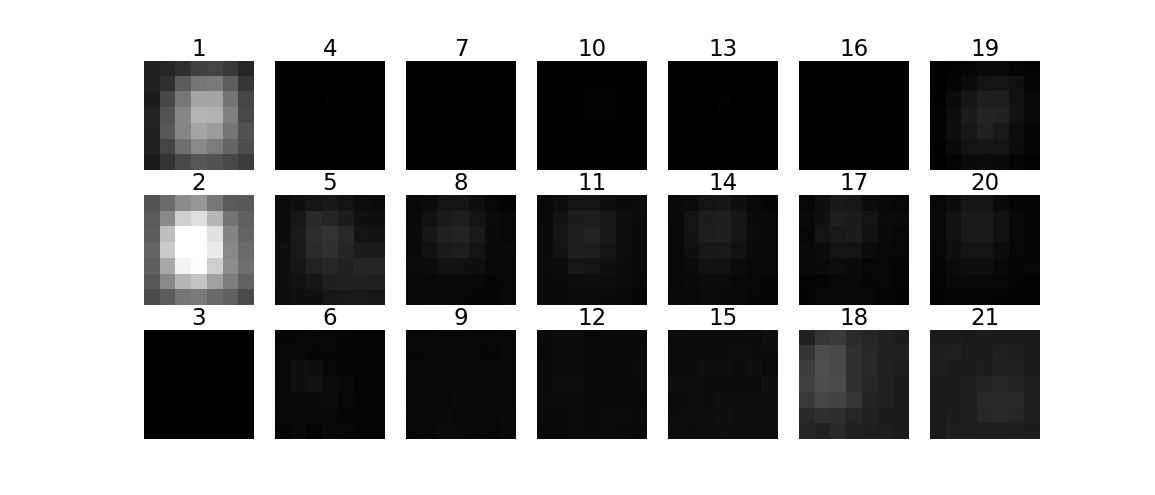

In [158]:
# site 1 image
%matplotlib notebook
fig, axes = plt.subplots(3,int(len(intbc_ims)/3), sharex=True, sharey=True, 
                         figsize=(len(intbc_ims)/3,3), dpi=150)
plt.subplots_adjust(wspace=0.2, hspace=0.2)
for _iax, ax in enumerate(np.ravel(axes.transpose())):
    ax.imshow(intbc_ims[_iax].max(0), 
              vmin=scoreatpercentile(intbc_ims, 30), 
              vmax=scoreatpercentile(intbc_ims, 99.95), 
              cmap='Greys_r')
    ax.set_axis_off()
    ax.set_title(f"{intbc_ids[_iax]}", fontsize=10, pad=1)

#fig.suptitle(f'intbcs, spot:{cell_id}', fontsize=12)
plt.show()

<IPython.core.display.Javascript object>


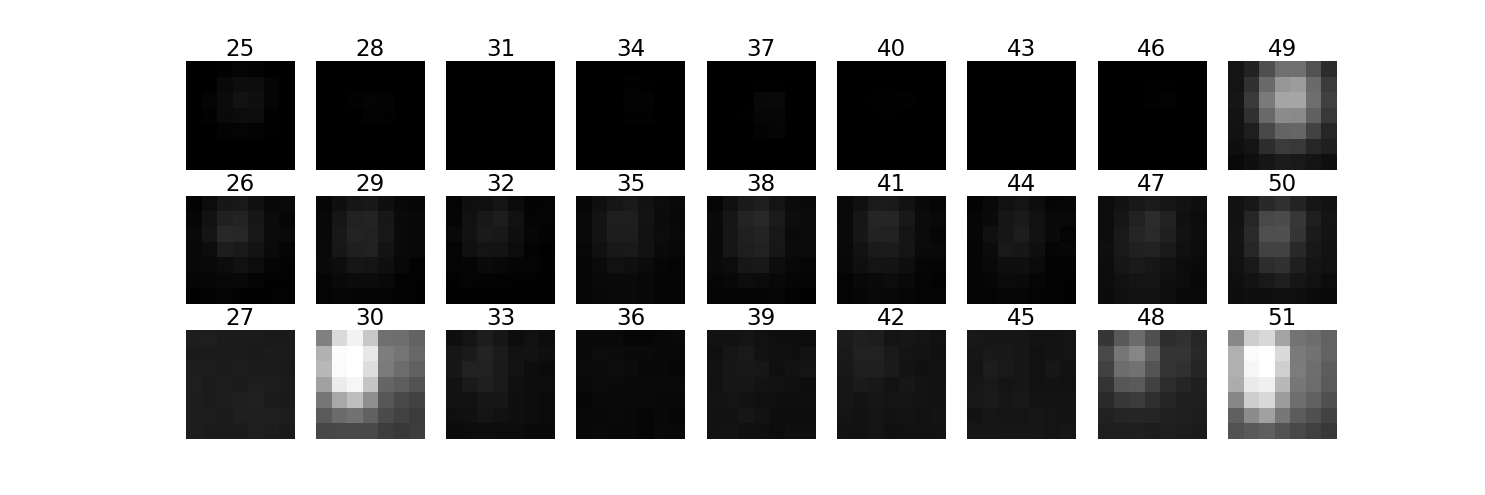

In [159]:
# site 1 image
%matplotlib notebook
fig, axes = plt.subplots(3,int(len(edit_ims)/3), sharex=True, sharey=True, 
                         figsize=(len(edit_ims)/3,3), dpi=150)
plt.subplots_adjust(wspace=0.2, hspace=0.2)
for _iax, ax in enumerate(np.ravel(axes.transpose())):
    ax.imshow(edit_ims[_iax].max(0), 
              vmin=scoreatpercentile(edit_ims, 30), 
              vmax=scoreatpercentile(edit_ims, 99.95), 
              cmap='Greys_r')
    ax.set_axis_off()
    ax.set_title(f"{edit_ids[_iax]}", fontsize=10, pad=1)

#fig.suptitle(f'edits, spot:{cell_id}', fontsize=12)
plt.show()

In [ ]:
    # Colocalize r2 and m53
    r2_spots = _rna_spots[list(_rna_ids).index(2)]#[:,1:4]

    sv40_spots = _merfish_spots[list(_merfish_ids).index(53)]#[:,1:4]

    sv40_im = _merfish_ims[list(_merfish_ids).index(53)]
    paired_sv40_spots, paired_r2_spots = colocalize_spots(sv40_spots, r2_spots)
    if len(paired_sv40_spots) == 0:
        continue

In [26]:
plt.style.use('dark_background')

<IPython.core.display.Javascript object>


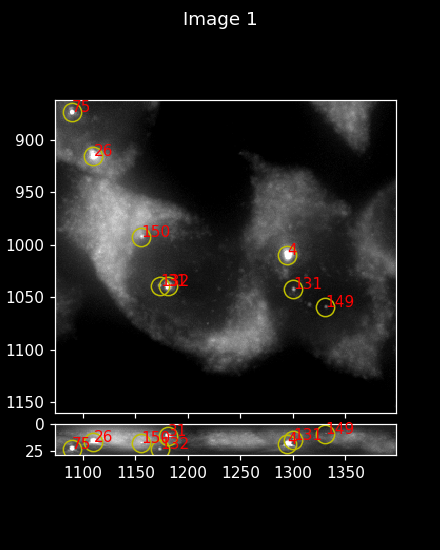

In [28]:
coord_dict = {
    'class_ids': np.concatenate([np.zeros(len(paired_sv40_spots)).astype(np.int32),
                                 np.ones(len(paired_r2_spots)).astype(np.int32)]),
    'coords': np.concatenate([paired_sv40_spots.to_coords(),
                              paired_r2_spots.to_coords()]),
}
%matplotlib notebook
interactive.imshow_mark_3d([sv40_im, _rna_ims[0]], use_dict=coord_dict)

<IPython.core.display.Javascript object>


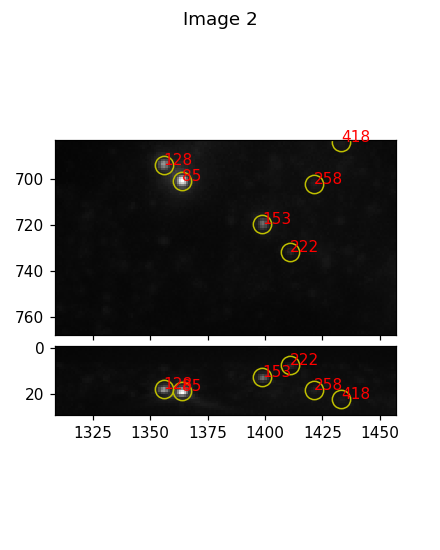

In [24]:
coord_dict = {
    'class_ids': np.concatenate([np.zeros(len(_merfish_spots[-1])).astype(np.int32),
                                 np.ones(len(_rna_spots[0])).astype(np.int32)]),
    'coords': np.concatenate([_merfish_spots[-1].to_coords(),
                              _rna_spots[0].to_coords()]),
}
%matplotlib notebook
interactive.imshow_mark_3d([_merfish_ims[-1], _rna_ims[0]], use_dict=coord_dict)

<IPython.core.display.Javascript object>


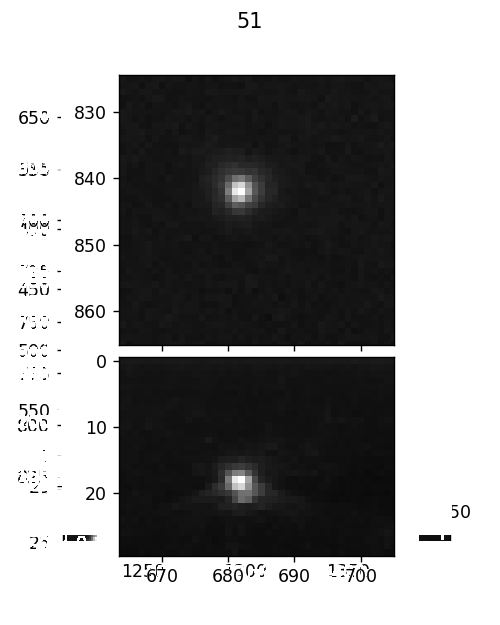

In [11]:
%matplotlib notebook
interactive.imshow_mark_3d(_merfish_ims[-8:], image_names=_merfish_ids[-8:])

In [44]:

# Colocalize r2 and m53
r2_spots = _rna_spots[list(_rna_ids).index(2)]#[:,1:4]

sv40_spots = _merfish_spots[list(_merfish_ids).index(53)]#[:,1:4]

sv40_im = _merfish_ims[list(_merfish_ids).index(53)]
paired_sv40_spots, paired_r2_spots = colocalize_spots(sv40_spots, r2_spots)


-- 119 pairs found


In [ ]:
paired_sv40_spots

In [12]:
processed_fov_files = [os.path.join(analysis_folder, _fl) for _fl in os.listdir(analysis_folder) if '_processed_info.pkl' in _fl]
len(processed_fov_files)

1

In [13]:
Edit_ims_list = []
for _fovinfo_savefile in processed_fov_files:
    print(_fovinfo_savefile)
    _fov_save_infos = pickle.load(open(_fovinfo_savefile, 'rb'))
    for _infos in _fov_save_infos:
        Edit_ims_list.append(_infos['edit_ims'])
    

/lab/weissman_imaging/puzheng/PE_LT/20231030-top8preEdit400k_zombie/Analysis/Conv_zscan_000_processed_info.pkl


In [14]:
intbc_ims_list = []
for _fovinfo_savefile in processed_fov_files:
    print(_fovinfo_savefile)
    _fov_save_infos = pickle.load(open(_fovinfo_savefile, 'rb'))
    for _infos in _fov_save_infos:
        intbc_ims_list.append(_infos['intbc_ims'])
    

/lab/weissman_imaging/puzheng/PE_LT/20231030-top8preEdit400k_zombie/Analysis/Conv_zscan_000_processed_info.pkl


In [15]:
len(intbc_ims_list), len(Edit_ims_list)

(119, 119)

In [26]:
edit_normalize = np.median(Edit_ims_list, axis=(0,2,3,4))

In [27]:
intbc_normalize = np.median(intbc_ims_list, axis=(0,2,3,4))

In [44]:
cell_id = 300
test_intbc_ims = intbc_ims_list[cell_id] / intbc_normalize[:, np.newaxis, np.newaxis, np.newaxis]

In [45]:
test_edit_ims = Edit_ims_list[cell_id] / edit_normalize[:, np.newaxis, np.newaxis, np.newaxis]

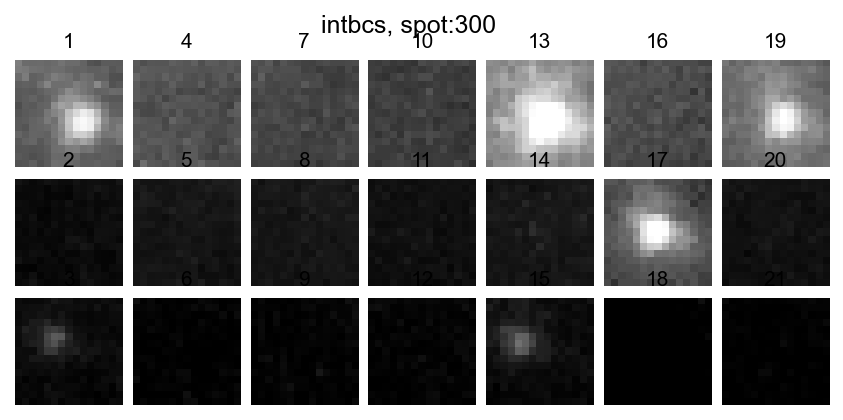

In [46]:
# site 1 image
fig, axes = plt.subplots(3,int(len(test_intbc_ims)/3), sharex=True, sharey=True, 
                         figsize=(len(test_intbc_ims)/3,3), dpi=150)
plt.subplots_adjust(wspace=0.1, hspace=0.1)
for _iax, ax in enumerate(np.ravel(axes.transpose())):
    ax.imshow(test_intbc_ims[_iax].max(0), 
              vmin=scoreatpercentile(test_intbc_ims, 30), 
              vmax=scoreatpercentile(test_intbc_ims, 99.9), 
              cmap='Greys_r')
    ax.set_axis_off()
    ax.set_title(f"{intbc_ids[_iax]}", fontsize=10)

fig.suptitle(f'intbcs, spot:{cell_id}', fontsize=12)
plt.show()

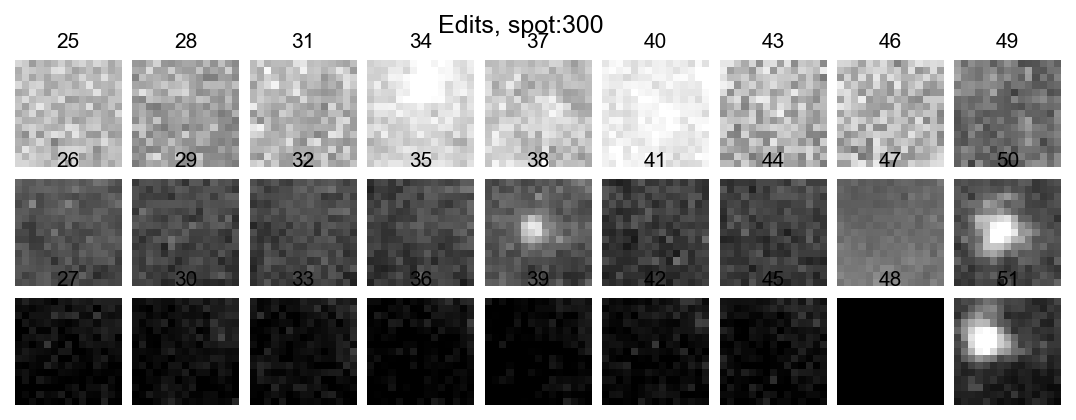

In [47]:
# site 1 image
%matplotlib inline
fig, axes = plt.subplots(3,int(len(test_edit_ims)/3), sharex=True, sharey=True, 
                         figsize=(len(test_edit_ims)/3,3), dpi=150)
plt.subplots_adjust(wspace=0.1, hspace=0.1)
for _iax, ax in enumerate(np.ravel(axes.transpose())):
    ax.imshow(test_edit_ims[_iax].max(0), 
              vmin=scoreatpercentile(test_edit_ims, 30), 
              vmax=scoreatpercentile(test_edit_ims, 99.9), 
              cmap='Greys_r')
    ax.set_axis_off()
    ax.set_title(f"{edit_ids[_iax]}", fontsize=10)

fig.suptitle(f'Edits, spot:{cell_id}', fontsize=12)
plt.show()

In [12]:
from ChromAn.src.file_io.image_crop import generate_neighboring_crop,crop_neighboring_area
from scipy.stats import scoreatpercentile
import matplotlib.pyplot as plt
def _rescaling(im, vmin=None, vmax=None):
    if vmin is None:
        vmin = np.min(im)
    if vmax is None:
        vmax = np.max(im)
    _res_im = np.clip(im, vmin, vmax)
    _res_im = (_res_im - vmin) / (vmax - vmin)
    _res_im = (_res_im * np.iinfo(np.uint8).max ).astype(np.uint8)
    return _res_im

def rescale_by_percentile(im, min_max_percent=[30,99.95]):
    from scipy.stats import scoreatpercentile
    vmin, vmax = scoreatpercentile(im, min(min_max_percent)), scoreatpercentile(im, max(min_max_percent))
    return _rescaling(im, vmin=vmin, vmax=vmax)

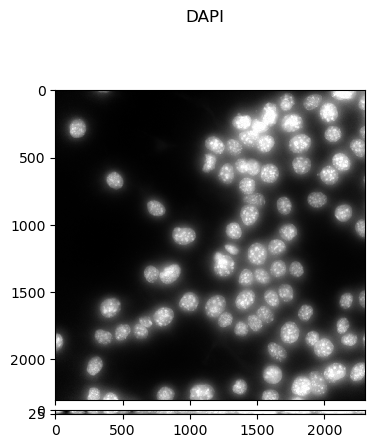

In [403]:
interactive.imshow_mark_3d([_dapi_im, sv40_im], image_names=['DAPI', 'SV40'])

<IPython.core.display.Javascript object>


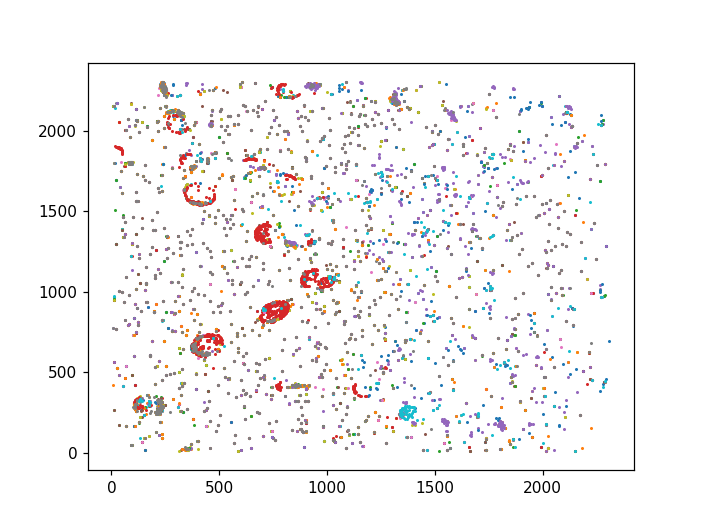

In [404]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.figure()
for _spots in _spots_list:
    plt.scatter(_spots[:,3],_spots[:,2], s= 1)

In [53]:
# crop intbc images:
sel_center = _spots_list[list(_ids).index(53)][12,1:4]
sel_local_im = crop_neighboring_area(_ims[list(_ids).index(53)], sel_center, 100)

intbc_ids = _ids[_ids <= 21]
edit_ids = _ids[(_ids > 21) & (_ids < 52)]

from ChromAn.src.file_io.image_crop import crop_neighboring_area
intbc_ims = []
for _id in intbc_ids:
    _idx = list(_ids).index(_id)
    # new center
    _im, _dft = _ims[_idx], _drifts[_idx]
    _local_im = crop_neighboring_area(_im, sel_center-_dft, 15)
    intbc_ims.append(_local_im)
    #break
# crop edit images:
edit_ims = []
for _id in edit_ids:
    _idx = list(_ids).index(_id)
    # new center
    _im, _dft = _ims[_idx], _drifts[_idx]
    _local_im = crop_neighboring_area(_im, sel_center-_dft, 15)
    edit_ims.append(_local_im)
    #break

NameError: name '_spots_list' is not defined

<IPython.core.display.Javascript object>


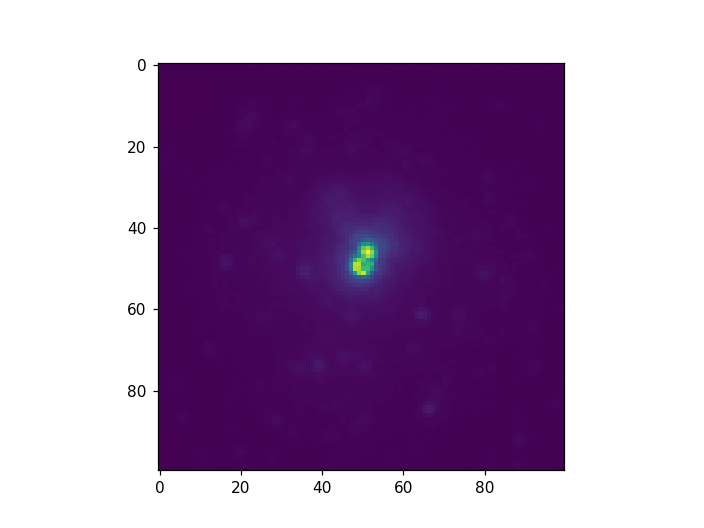

In [392]:
fig, ax = plt.subplots()
ax.imshow(sel_local_im.max(0))

interactive.imshow_mark_3d([sel_local_im] + intbc_ims, image_names=['ref'] + list(intbc_ids))

Text(0.5, 0.98, 'Integration barcode')

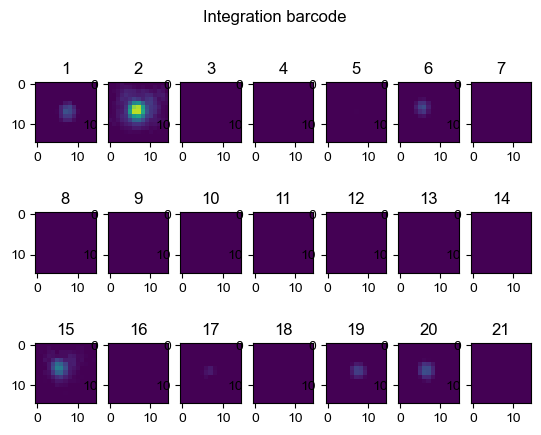

In [64]:
fig, axes = plt.subplots(3,7)
for _iax, ax in enumerate(np.ravel(axes)):
    ax.imshow(intbc_ims[_iax].max(0), vmin=4000, vmax=20000)
    ax.set_title(f"{_iax+1}")
fig.suptitle('Integration barcode')

Text(0.5, 0.98, 'Edits')

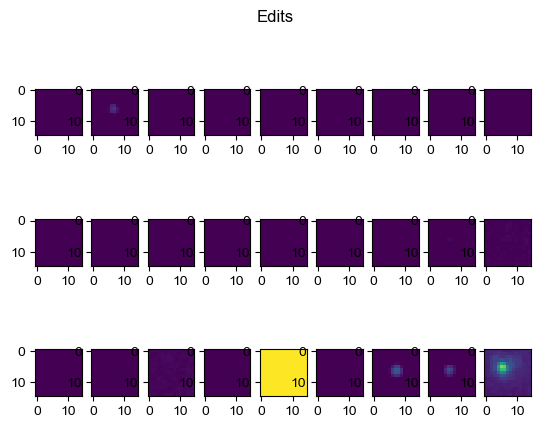

In [63]:
fig, axes = plt.subplots(3,9)
for _iax, ax in enumerate(np.ravel(axes)):
    ax.imshow(edit_ims[_iax].max(0) , vmin=4000, vmax=20000)
fig.suptitle('Edits')

In [396]:
def _rescaling(im, vmin=None, vmax=None):
    if vmin is None:
        vmin = np.min(im)
    if vmax is None:
        vmax = np.max(im)
    _res_im = np.clip(im, vmin, vmax)
    _res_im = (_res_im - vmin) / (vmax - vmin)
    _res_im = (_res_im * np.iinfo(np.uint8).max ).astype(np.uint8)
    return _res_im

def rescale_by_percentile(im, min_max_percent=[30,99.95]):
    from scipy.stats import scoreatpercentile
    vmin, vmax = scoreatpercentile(im, min(min_max_percent)), scoreatpercentile(im, max(min_max_percent))
    return _rescaling(im, vmin=vmin, vmax=vmax)

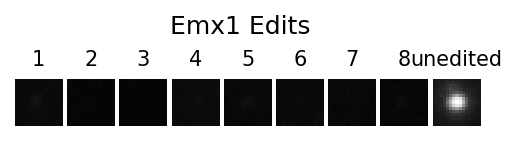

In [398]:
%matplotlib inline
site1_edit_ims = np.array(edit_ims[0::3])

fig, axes = plt.subplots(1,len(site1_edit_ims), sharex=True, sharey=True, figsize=(4,1.2), dpi=150)
plt.subplots_adjust(wspace=0.1, hspace=0.1)
for _iax, ax in enumerate(np.ravel(axes)):
    ax.imshow(site1_edit_ims[_iax].max(0), 
              vmin=scoreatpercentile(site1_edit_ims, 0), 
              vmax=np.max(site1_edit_ims), cmap='Greys_r')
    ax.set_axis_off()
    if _iax < 8:
        ax.set_title(f"{_iax+1}", fontsize=10)
    else:
        ax.set_title("unedited", fontsize=10)
    
fig.suptitle('Emx1 Edits', fontsize=12)
plt.show()


In [ ]:
%matplotlib inline
# mass plot
from ChromAn.src.file_io.image_crop import generate_neighboring_crop
from scipy.stats import scoreatpercentile

figure_folder = os.path.join(analysis_folder, 'saved_figures_20231012')
if not os.path.exists(figure_folder):
    os.makedirs(figure_folder)

# crop intbc images:
spot_id = np.arange(30)
for _sid in spot_id:
    sel_center = _spots_list[list(_ids).index(53)][_sid,1:4]

    
    crop = generate_neighboring_crop(sel_center, 150, single_im_size=np.array(_dapi_im.shape))
    sel_local_dapi_im = _dapi_im[crop.to_slices()]
    sel_local_im = _ims[list(_ids).index(53)][crop.to_slices()]
    _sel_ims = np.array([sel_local_im, np.zeros(np.shape(sel_local_im)), sel_local_dapi_im])
    sel_im_proj = np.array([rescale_by_percentile(_img.max(0)) 
                            for _img in _sel_ims]).transpose(1,2,0)

    #intbc_ids = _ids[_ids <= 21]
    edit_ids = _ids[(_ids > 21) & (_ids < 52)]

    # crop edit images:
    edit_ims = []
    for _id in edit_ids:
        _idx = list(_ids).index(_id)
        # new center
        _im, _dft = _ims[_idx], _drifts[_idx]
        _local_im = crop_neighboring_area(_im, sel_center-_dft, 15)
        edit_ims.append(_local_im)
        #break
    # site 1 image
    site1_edit_ims = np.array(edit_ims[0::3])
    fig, axes = plt.subplots(1,len(site1_edit_ims), sharex=True, sharey=True, figsize=(4,1.2), dpi=150)
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    for _iax, ax in enumerate(np.ravel(axes)):
        ax.imshow(site1_edit_ims[_iax].max(0), 
                  vmin=scoreatpercentile(site1_edit_ims, 0), 
                  vmax=np.max(site1_edit_ims), cmap='Greys_r')
        ax.set_axis_off()
        if _iax < 8:
            ax.set_title(f"{_iax+1}", fontsize=10)
        else:
            ax.set_title("unedited", fontsize=10)

    fig.suptitle(f'Emx1 Edits, spot:{_sid}', fontsize=12)
    fig.savefig(os.path.join(figure_folder,
                            os.path.basename(_save_filename).replace('.hdf5',f'_Emx1edits_decode_{_sid}.png')),
                transparent=True,
               )
    plt.show()
    # dapi image
    fig,ax = plt.subplots(figsize=(4,4), dpi=150)
    ax.imshow(sel_im_proj)
    ax.set_title(f"R:SV40, B:DAPI", fontsize=10)
    ax.set_axis_off()
    fig.savefig(os.path.join(figure_folder,
                            os.path.basename(_save_filename).replace('.hdf5',f'_Emx1edits_sv40Dapi_{_sid}.png')),
                transparent=True,
               )
    plt.show()

<IPython.core.display.Javascript object>


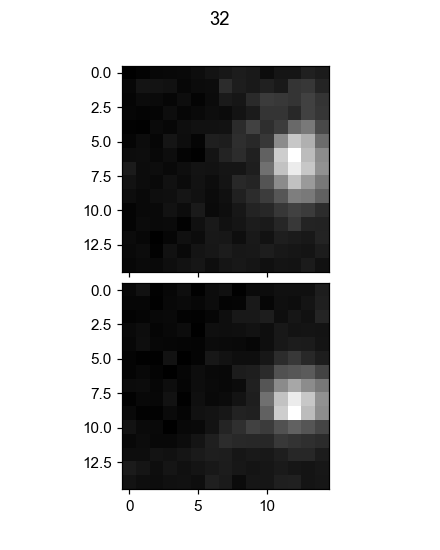

In [218]:
%matplotlib notebook
interactive.imshow_mark_3d([sel_local_im] + edit_ims, image_names=['ref'] + list(edit_ids))

In [54]:
np.sum(_ids <= 21)

21